In [1]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists

from scipy.misc import factorial
from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../GDAX/data/2016-10-09.trades.csv', index_col=0)
data.t = pd.to_datetime(1e9*data.t)

def consolidate(data):
    df = pd.DataFrame(columns=['t', 'px', 'sz', 'sd', 'bid', 'mid', 'ask'])
    df.px = (data.px * data.sz).groupby(data.t).sum() / data.groupby(data.t).sz.sum()
    df.sz = data.groupby(data.t).sz.sum()
    df.sd = list(map(lambda group: group[1].sd.iloc[-1], list(data.groupby(data.t))))
    df.bid = list(map(lambda group: group[1].bid.iloc[-1], list(data.groupby(data.t))))
    df.ask = list(map(lambda group: group[1].ask.iloc[-1], list(data.groupby(data.t))))
    df.mid = 0.5*(df.bid + df.ask)
    df.t = df.index
    df.index = range(len(df))
    return df
df = consolidate(data)

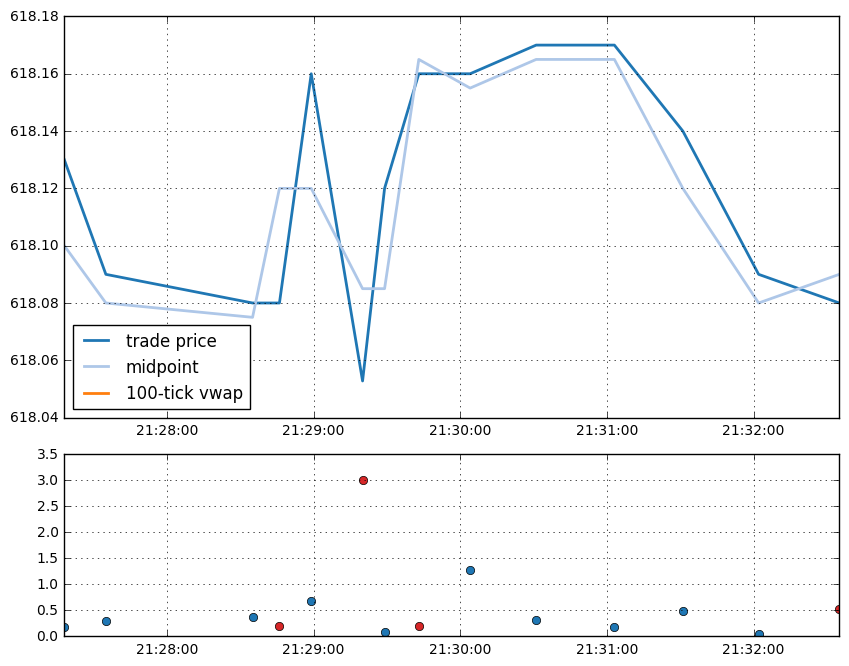

In [5]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

ax[0].plot(df.t, df.px, lw=2, label='trade price')
ax[0].plot(df.t, df.mid, lw=2, label='midpoint')
ax[0].plot(df.t, (df.px * df.sz).rolling(100).sum() / df.sz.rolling(100).sum(), lw=2, label='100-tick vwap')
#ax[1].plot(df.t, (df.sz * (df.sd == 'b')).cumsum(), '-', c=tableau[4])
#ax[1].plot(df.t, (df.sz * (df.sd == 's')).cumsum(), '-', c=tableau[3])
ax[1].plot(df.loc[df.sd == 'b'].t, df.sz.loc[df.sd == 'b'], 'o', c=tableau[0])
ax[1].plot(df.loc[df.sd == 's'].t, df.sz.loc[df.sd == 's'], 'o', c=tableau[6])

ax[0].xaxis.set_major_formatter(xfmt)
ax[0].yaxis.get_major_formatter().set_useOffset(False)
ax[0].legend(loc='lower left')
ax[1].xaxis.set_major_formatter(xfmt)

In [4]:
print('total ticks in dataset:       %d ticks' % (len(df)))
print('time elapsed over dataset:    %0.2f hours' % ((df.t.iloc[-1] - df.t.iloc[0]).total_seconds() / 3600))
print('average time between ticks:   %0.2f seconds' % ((df.t - df.t.shift(1)).mean().total_seconds()))
print('percent ticks are buys:       %0.1f%%' % (100.*len(df.loc[df.sd == 'b']) / len(df)))
print('avg. abs. px change on tick:  %0.1f cents' % (100.*abs(df.px - df.px.shift(1)).mean()))
print('std in px change on tick:     %0.1f cents' % (100.*(df.px - df.px.shift(1)).std()))

total ticks in dataset:       14 ticks
time elapsed over dataset:    0.09 hours
average time between ticks:   24.38 seconds
percent ticks are buys:       71.4%
avg. abs. px change on tick:  3.4 cents
std in px change on tick:     4.9 cents
